Using device: cuda
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:11<00:00, 895kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.19MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/20], Loss: 0.2563, Test Accuracy: 96.04%
Epoch [2/20], Loss: 0.1242, Test Accuracy: 97.02%
Epoch [3/20], Loss: 0.0953, Test Accuracy: 97.31%
Epoch [4/20], Loss: 0.0796, Test Accuracy: 97.62%
Epoch [5/20], Loss: 0.0699, Test Accuracy: 97.75%
Epoch [6/20], Loss: 0.0634, Test Accuracy: 97.77%
Epoch [7/20], Loss: 0.0576, Test Accuracy: 97.84%
Epoch [8/20], Loss: 0.0545, Test Accuracy: 98.11%
Epoch [9/20], Loss: 0.0538, Test Accuracy: 98.09%
Epoch [10/20], Loss: 0.0486, Test Accuracy: 97.92%
Epoch [11/20], Loss: 0.0258, Test Accuracy: 98.39%
Epoch [12/20], Loss: 0.0183, Test Accuracy: 98.55%
Epoch [13/20], Loss: 0.0160, Test Accuracy: 98.57%
Epoch [14/20], Loss: 0.0139, Test Accuracy: 98.53%
Epoch [15/20], Loss: 0.0129, Test Accuracy: 98.57%
Epoch [16/20], Loss: 0.0121, Test Accuracy: 98.50%
Epoch [17/20], Loss: 0.0107, Test Accuracy: 98.57%
Epoch [18/20], Loss: 0.0107, Test Accuracy: 98.63%
Epoch [19/20], L

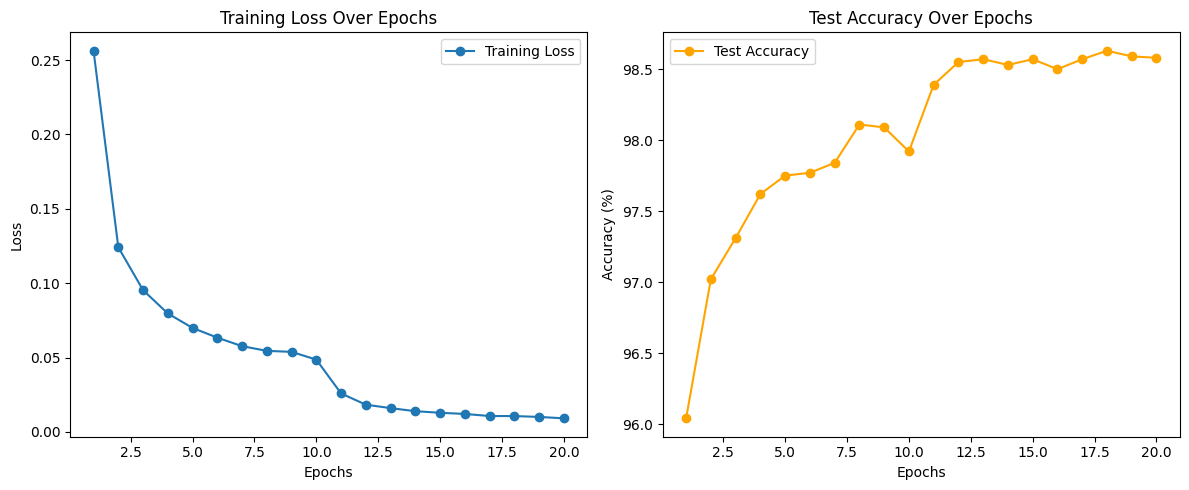

Model saved as mnist_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and normalize the MNIST dataset (Standard Normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalization values for MNIST
])

# Download the training and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  # Reduced batch size for efficiency

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Define a neural network with improved architecture and weight initialization
class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)  # First fully connected layer
        self.fc2 = nn.Linear(256, 128)       # Second fully connected layer
        self.fc3 = nn.Linear(128, 10)        # Output layer for 10 classes (digits 0-9)
        self.relu = nn.ReLU()                 # ReLU activation function
        self.dropout = nn.Dropout(0.2)       # Dropout layer to reduce overfitting

        # Initialize weights using Kaiming Normal initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))  # Apply first layer and ReLU
        x = self.dropout(x)          # Apply dropout
        x = self.relu(self.fc2(x))  # Apply second layer and ReLU
        x = self.fc3(x)              # Output layer
        return x  # Return raw logits (softmax will be applied in the loss function)

# Initialize the model, loss function, and optimizer
model = ImprovedNN().to(device)
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Adam optimizer with L2 regularization

# Training loop with learning rate scheduling
num_epochs = 20
train_losses = []
test_accuracies = []
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR every 10 epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()  # Accumulate loss

    avg_loss = total_loss / len(trainloader)  # Average loss for the epoch
    train_losses.append(avg_loss)

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0

    with torch.no_grad():  # Disable gradient tracking
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted classes
            total += labels.size(0)  # Total number of labels
            correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = 100 * correct / total  # Calculate accuracy
    test_accuracies.append(accuracy)
    scheduler.step()  # Adjust learning rate

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

# Plot training loss and test accuracy
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'o-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, 'o-', label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Save the trained model
model_path = "mnist_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved as {model_path}")

# Download the model to your local system (if using Google Colab)
from google.colab import files
files.download(model_path)
